
# Next-Day Price Forecast with Stochastic Process Models

This notebook estimates parameters for **Geometric Brownian Motion (GBM)** on historical data
and produces a **distribution for tomorrow's price** using Monte Carlo simulation.
It also provides an optional **AR(1) on log-returns** baseline and compares forecasts.

> **How to use**
> 1. Run the cells from top to bottom.
> 2. Adjust the **Parameters** cell for tickers, lookback window, and simulation settings.
> 3. Review the **Summary table** and **plots** for each ticker.


In [ ]:

# =========================
# Parameters (edit me)
# =========================
TICKERS = ["RELIANCE.NS"]  # NSE examples; use '.NS' suffix
LOOKBACK_YEARS = 15          # number of years of daily data to pull
SIMULATIONS = 20000         # Monte Carlo paths for next-day price
CONF_LEVEL = 0.90           # predictive interval for next-day price (e.g., 0.90 => 5%/95%)
RISK_FREE_ANNUAL = 0.06     # optional: for drift comparison (not directly used in GBM MLE)
USE_AR1_BASELINE = True     # also fit AR(1) on log-returns for comparison
OUTPUT_CSV = "next_day_forecast_results.csv"  # summary per ticker
RANDOM_SEED = 42            # for reproducibility
# =========================


In [2]:

# Install dependencies if needed (uncomment when running locally)
# %pip install yfinance pandas numpy scipy matplotlib statsmodels

import math
import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt

np.random.seed(RANDOM_SEED)

# Utility: annualization helpers for daily data (approx 252 trading days/year)
TRADING_DAYS = 252

def annualize_mu_sigma(mu_daily, sigma_daily):
    mu_ann = mu_daily * TRADING_DAYS
    sigma_ann = sigma_daily * math.sqrt(TRADING_DAYS)
    return mu_ann, sigma_ann


In [3]:

from datetime import datetime, timedelta

end = datetime.today() - timedelta(days=1)
start = end - timedelta(days=int(LOOKBACK_YEARS * 365.25))

def get_data(ticker):
    df = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False, multi_level_index=False)
    if df.empty:
        raise ValueError(f"No data for {ticker}. Check ticker symbol or internet connectivity.")
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    df['LogClose'] = np.log(df['Close'])
    df['LogRet'] = df['LogClose'].diff()
    df = df.dropna()
    return df

# quick test fetch for the first ticker (will raise if offline)
# _ = get_data(TICKERS[0])
print(f"Date range planned: {start.date()} → {end.date()}")


Date range planned: 2010-09-13 → 2025-09-12


In [4]:

def fit_gbm_mle(log_returns: pd.Series):
    """
    For GBM S_t: dS/S = mu dt + sigma dW  => log-returns ~ N((mu - 0.5 sigma^2) dt, sigma^2 dt).
    With dt=1 day, estimate:
      sigma^2 = Var(log_returns)
      mu = mean(log_returns) + 0.5 * sigma^2
    Returns (mu_daily, sigma_daily).
    """
    m = log_returns.mean()
    v = log_returns.var(ddof=1)
    sigma = math.sqrt(v)
    mu = m + 0.5 * v
    return mu, sigma

def gbm_next_day_distribution(S_t, mu_daily, sigma_daily, n_sims=10000):
    """Simulate next-day price under GBM (1 step)."""
    z = np.random.normal(size=n_sims)
    S_next = S_t * np.exp((mu_daily - 0.5 * sigma_daily**2) + sigma_daily * z)
    return S_next

def predictive_interval(samples, conf=0.90):
    low = (1 - conf) / 2
    high = 1 - low
    return np.quantile(samples, [low, 0.5, high])  # (lo, median, hi)


In [5]:

def fit_ar1(log_returns: pd.Series):
    # Fit AR(1): r_t = c + phi * r_{t-1} + e_t
    model = AutoReg(log_returns, lags=1, old_names=False)
    res = model.fit()
    return res

def ar1_next_day_forecast(S_t, last_ret, res):
    # Forecast next log-return (mean), assume Normal with residual std
    phi = res.params.get('L1.LogRet', 0.0)
    c = res.params.get('const', 0.0)
    mu_ret = c + phi * last_ret
    sigma_ret = np.std(res.resid, ddof=1)
    # one-day price distribution (Normal on log-return)
    z = np.random.normal(size=SIMULATIONS)
    r_next = mu_ret + sigma_ret * z
    S_next = S_t * np.exp(r_next)
    return S_next, mu_ret, sigma_ret



=== RELIANCE.NS ===


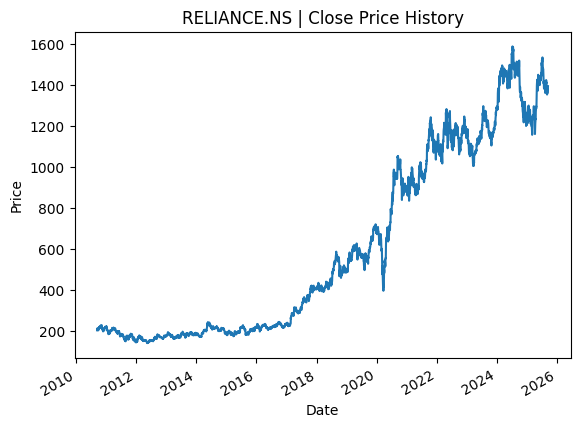

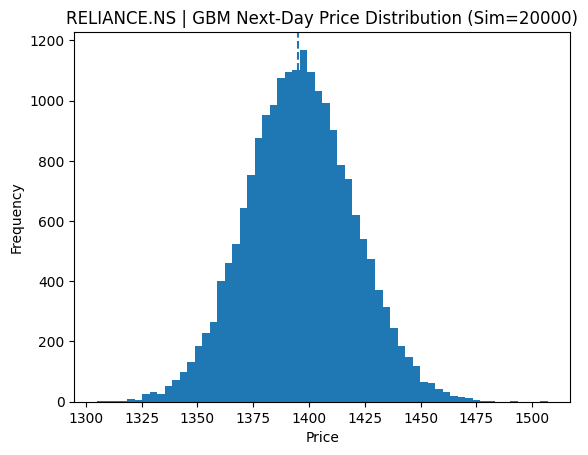

,Ticker,Today_Close,GBM_mu_daily,GBM_sigma_daily,GBM_mu_annual,GBM_sigma_annual,GBM_E[S_t+1],GBM_PI_low,GBM_PI_med,GBM_PI_high,GBM_P(up),AR1_E[S_t+1],AR1_PI_low,AR1_PI_med,AR1_PI_high,AR1_P(up)
0,RELIANCE.NS,1395.0,0.000667,0.017137,0.168135,0.272041,1396.068301,1357.383152,1395.910292,1435.907846,0.5143,NaN,NaN,NaN,NaN,NaN


In [6]:

rows = []

for ticker in TICKERS:
    print(f"\n=== {ticker} ===")
    df = get_data(ticker)

    S_t = df['Close'].iloc[-1]
    last_ret = df['LogRet'].iloc[-1]

    # --- GBM fit ---
    mu_d, sigma_d = fit_gbm_mle(df['LogRet'])
    mu_ann, sigma_ann = annualize_mu_sigma(mu_d, sigma_d)
    sims_gbm = gbm_next_day_distribution(S_t, mu_d, sigma_d, n_sims=SIMULATIONS)
    lo_gbm, med_gbm, hi_gbm = predictive_interval(sims_gbm, conf=CONF_LEVEL)
    p_up_gbm = (sims_gbm > S_t).mean()
    exp_gbm = sims_gbm.mean()

    # --- Optional AR(1) baseline ---
    if USE_AR1_BASELINE:
        res = fit_ar1(df['LogRet'])
        sims_ar1, mu_ret, sigma_ret = ar1_next_day_forecast(S_t, last_ret, res)
        lo_ar1, med_ar1, hi_ar1 = predictive_interval(sims_ar1, conf=CONF_LEVEL)
        p_up_ar1 = (sims_ar1 > S_t).mean()
        exp_ar1 = sims_ar1.mean()
    else:
        lo_ar1 = med_ar1 = hi_ar1 = p_up_ar1 = exp_ar1 = np.nan

    rows.append({
        "Ticker": ticker,
        "Today_Close": S_t,
        # GBM
        "GBM_mu_daily": mu_d,
        "GBM_sigma_daily": sigma_d,
        "GBM_mu_annual": mu_ann,
        "GBM_sigma_annual": sigma_ann,
        "GBM_E[S_t+1]": exp_gbm,
        "GBM_PI_low": lo_gbm,
        "GBM_PI_med": med_gbm,
        "GBM_PI_high": hi_gbm,
        "GBM_P(up)": p_up_gbm,
        # AR(1)
        "AR1_E[S_t+1]": exp_ar1,
        "AR1_PI_low": lo_ar1,
        "AR1_PI_med": med_ar1,
        "AR1_PI_high": hi_ar1,
        "AR1_P(up)": p_up_ar1,
    })

    # --------- Plots (each chart as its own figure) ---------
    # 1) Historical price
    plt.figure()
    df['Close'].plot(title=f"{ticker} | Close Price History")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()

    # 2) Next-day distribution (GBM)
    plt.figure()
    plt.hist(sims_gbm, bins=60)
    plt.axvline(S_t, linestyle="--")
    plt.title(f"{ticker} | GBM Next-Day Price Distribution (Sim={len(sims_gbm)})")
    plt.xlabel("Price")
    plt.ylabel("Frequency")
    plt.show()

    # 3) Next-day distribution (AR1) if used
    if USE_AR1_BASELINE:
        plt.figure()
        plt.hist(sims_ar1, bins=60)
        plt.axvline(S_t, linestyle="--")
        plt.title(f"{ticker} | AR(1) Next-Day Price Distribution (Sim={len(sims_ar1)})")
        plt.xlabel("Price")
        plt.ylabel("Frequency")
        plt.show()

summary = pd.DataFrame(rows)
summary.to_csv(OUTPUT_CSV, index=False)
summary



## Interpretation Guide

- **GBM\_mu\_daily / sigma\_daily**: Estimated daily drift and volatility of log-returns.
- **GBM\_mu\_annual / sigma\_annual**: Annualized versions (×252, ×√252).
- **GBM\_E[S_{t+1}]**: Expected price tomorrow under GBM.
- **GBM\_PI\_low/med/high**: Predictive interval bounds and median for next-day price.
- **GBM\_P(up)**: Monte Carlo probability that price is higher than today.
- **AR1\_...**: Same fields using an AR(1) on log-returns (mean + Normal noise).

**Notes**  
- GBM assumes **log-normal** one-step dynamics; AR(1) allows small mean reversion/momentum in returns.  
- Short-horizon stock prices are noisy; treat probabilities as **indicative**, not guarantees.  
- Consider adding microstructure filters, corporate actions checks, and outlier handling for production use.
